<a id='Notebook_Date'></a> Created: 2024/05/06

<a id='sec_Introducción_al_Algoritmo_VQE'></a>
# Introducción  al Algoritmo VQE

In [1]:
# Librerías generales
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product
import random
import scipy
import matplotlib.pyplot as plt

# Librerías Qibo
import qibo
from qibo import models, gates, hamiltonians
from qibo import matrices as m

# Librerías Qiskit
import qiskit
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit.library import TwoLocal
from qiskit.tools.parallel import parallel_map

random.seed()

qibo.set_backend("numpy")

%matplotlib inline

/tmp/ipykernel_30678/2196755265.py:19: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
[Qibo 0.1.12.dev0|INFO|2024-04-17 11:04:26]: Using numpy backend on /CPU:0


<a id='sec_Índice'></a>
## Índice

- [Introducción al Algoritmo](#sec_Introducción_al_Algoritmo)

    - [Programando el Algoritmo VQE](#sec_Programando_el_Algoritmo_VQE)
    
- [Bibliografía](#sec_Bibliografía)

A lo largo de este documento vamos a explicar y ejemplificar el funcionamiento del algoritmo VQE. Para ello haremos uso de la librería de software libre __[Qibo](https://qibo.science/)__. Puede encontrar más información sobre el proceso de instalación [aquí](https://qibo.science/docs/qibo/stable). Así mismo, en la sección [La Molécula de $H_2$](#sec_La_Molécula_de_H2) de este documento hacemos uso de la librería __[OpenFermion](https://quantumai.google/openfermion)__, desarrollada por Google. Puede encontrar [aquí](https://quantumai.google/openfermion/install) instrucciones para su instalación. También en esta sección hacemos uso de la librería de química computacional __[PySCF](https://pyscf.org/)__. Puede consultar las instrucciones de instalación [aquí](https://pyscf.org/install.html).

<a id='sec_Introducción_al_Algoritmo'></a>
## Introducción al Algoritmo

El algoritmo VQE (Variational Quantum Eigensolver) es un algoritmo que busca obtener el autovalor más pequeño de un operador. Se originó en el campo de la química computacional [[1]](#bib_peruzzo_variational_2014), donde se propuso para encontrar el estado fundamental de moléculas, aunque tiene aplicaciones en muchos otros campos [[2]](#bib_tilly_variational_2022).
<br>
<br>
Se trata de un **algoritmo híbrido**, pues combina computación cuántica y clásica. Utiliza un circuito cuántico parametrizado para generar estados cuánticos y posteriormente medir el valor esperado del operador. Este valor esperado se utilizará como función de coste para un **optimizador clásico**, que se encargará de ir variando los parámetros del circuito y devolviéndolos al sistema cuántico de forma iterativa hasta encontrar el autovalor mínimo.
<br>
<br>
El circuito parametrizado, conocido como **ansatz**, será equivalente a un operador unitario que llamaremos $U(\boldsymbol{\theta})$, en el que $\boldsymbol{\theta}$ es un vector que contiene todos los parámetros del circuito. Este actuará sobre nuestros qubits inicialidados en el estado que más nos interese según la aplicación. Esto generará un estado parametrizado $|\Psi(\boldsymbol{\theta}) \rangle$. Esto nos permite explorar un **subespacio del espacio de Hilbert**. En este sentido, la elección del ansatz y el estado incial es crucial, ya que de esto depende en gran medida si conseguiremos encontrar el valor mínimo o no.
<br>
<br>
Sobre ese estado parametrizado podremos medir el valor esperado del operador problema $\mathcal{H}$. Este valor será, al igual que el estado, dependiente de los parámetros del *ansatz*, y lo denotamos por $E(\boldsymbol{\theta})$. Utilizaremos este valor como función de coste para un optimizador clásico, de manera que tras un número suficiente de iteraciones conseguiremos una muy buena aproximación del autovalor más pequeño de nuestro operador $E_{G}$.

El funcionamiento del circuito sería algo así:

<figure><center>
<a id='fig_flux_diagram'></a>
<img src="pictures/VQE_flux.png" alt="Diagrama--de--flujo--del--algoritmo--VQE.--En--primer--lugar--tenemos--un--problema--caracterizado--por--un--operador--$\mathcal{H}$.--Codificamos--ese--problema--en--un--circuito--cuántico--con--puertas--parametrizadas.--De--ahí--realizamos--un--proceso--de--optimización--clásico.--Si--no--converge,--devolvemos--los--datos--al--circuito--cuántico.--Si--converge,--tenemos--el--resultado--$E_G$." align=center width='1000px'/>
<center> Figura 1: Diagrama de flujo del algoritmo VQE. En primer lugar tenemos un problema caracterizado por un operador $\mathcal{H}$. Codificamos ese problema en un circuito cuántico con puertas parametrizadas. De ahí realizamos un proceso de optimización clásico. Si no converge, devolvemos los datos al circuito cuántico. Si converge, tenemos el resultado $E_G$.</center>
</center></figure>

<a id='sec_Programando_el_Algoritmo_VQE'></a>
### Programando el Algoritmo VQE

Vamos a ver el funcionamiento de este algoritmo para un caso trivial, programando "manualmente" siguiendo el método que se emplea en la referencia [[3]](#bib_zickert_hands_quantum_2022). Estas funciones son bastante ineficientes y no pueden competir con las funciones *built-in* en librerías como Qibo, Qiskit o Pennylane, pero nos ayudan a ver cada parte de forma individual. En las siguientes secciones analizaremos casos prácticos haciendo uso de estas funciones mejor optimizadas.
<br>
<br>
El problema a resolver es encontrar el autovalor más pequeño de la siguiente matriz $ 4 \times 4$: <br>
<br>
$$
\mathcal{H} = \begin{bmatrix}
2.5 & -1 & -0.5 & 0 \\
-1 & 2.5 & 0 & 0.5 \\
-0.5 & 0 & 2.5 & 1 \\
0 & 0.5 & 1 & 2.5 
\end{bmatrix}
$$

Vamos a dejarla diagonalizada también con Python, para asegurarnos de que obtenemos los autovalores correctos:

In [2]:
op = np.array([[2.5,-1,-0.5,0],[-1,2.5,0,0.5],[-0.5,0,2.5,1],[0,0.5,1,2.5]], dtype=complex)

eigvals, eigvecs = scipy.linalg.eig(op)

print("Autovalores:", np.sort(np.real(eigvals)))
print("Autovalor mínimo:", np.real(np.round(min(eigvals))))

Autovalores: [1. 2. 3. 4.]
Autovalor mínimo: 1.0


Empezamos por definir las matrices de Pauli, ya que son los principales operadores que se utilizan en circuitería cuántica. Todo operador hermítico de dimensión $2^n$ (entre los que se incluye nuestro operador $\mathcal{H}$) puede descomponerse en productos tensoriales de matrices de Pauli. Estas, al ser hermíticas y unitarias, nos permiten tanto descomponer operadores como construir circuitos cuánticos.

In [3]:
PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0,1],[1,0]], dtype=complex),
    "Y": np.array([[0,-1j],[1j,0]], dtype=complex),
    "Z": np.array([[1,0],[0,-1]], dtype=complex)
}

Definimos la función ```pauli_decomposition(H)```, que toma nuestro operador matricial $\mathcal{H}$ y lo convierte en una cadena de matrices de Pauli. 

In [4]:
def pauli_decomposition(H):

    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]
    components = defaultdict(int)
    
    for i, val in enumerate(product(PAULIS.values(), repeat=n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()
        
        if not np.allclose(coeff,0):
            components[basis_key[i]] = coeff
            
    return components

In [5]:
components = pauli_decomposition(op)
components

defaultdict(int, {'II': 2.5, 'XZ': -0.5, 'ZX': -1.0})

Si volvemos a sumar nuestras componentes, vemos que se recupera nuestra matriz original $\mathcal{H}$.

In [6]:
restr = components['II']*np.kron(PAULIS["I"],PAULIS["I"]) + components['XZ']*np.kron(PAULIS["X"],PAULIS["Z"]) + components['ZX']*np.kron(PAULIS["Z"],PAULIS["X"])

print(restr)

if restr.all() == op.all(): print("\n Las dos matrices son iguales.")

[[ 2.5+0.j -1. +0.j -0.5+0.j  0. +0.j]
 [-1. +0.j  2.5+0.j  0. +0.j  0.5+0.j]
 [-0.5+0.j  0. +0.j  2.5+0.j  1. +0.j]
 [ 0. +0.j  0.5+0.j  1. +0.j  2.5+0.j]]

 Las dos matrices son iguales.


Definimos también la función ```ansatz```, que, tomando un circuito cuántico y un conjunto de parámetros, nos implementa el estado $|\psi (\boldsymbol{\theta})\rangle$ como un conjunto de operadores parametrizados.

In [7]:
'''Qibo_code_cell'''

def ansatz(circuit, nqubits, thetas, rounds=3):

    for r in range(rounds):
        for i in range(nqubits):
            offset = r*nqubits*2 + i*2
                        
            circuit.add(gates.RY(i, thetas[offset]))
            circuit.add(gates.RZ(i, thetas[offset+1]))
            
            if i > 0 and r < rounds - 1:
                circuit.add(gates.CNOT(i-1, i))
                
    return circuit

In [16]:
'''Qiskit_code_cell'''

def ansatz(qc, qr, thetas, rounds=3):
    
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r*len(qr)*2 + i*2
            
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset+1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i-1], qr[i])
                
    return qc

Veamos un ejemplo de ansatz que generaría este circuito si consideramos tres qubits:

In [8]:
'''Qibo_code_cell'''

nqubits = 3
nrounds = 4

qc = models.circuit.Circuit(nqubits)
angles = np.random.rand(2*nqubits*nrounds)

qc = ansatz(qc, nqubits=nqubits, thetas=angles, rounds=nrounds)

print(qc.draw())

q0: ─RY─RZ─o─────────RY─RZ─o─────────RY─RZ─o─────────RY─RZ─
q1: ─RY─RZ─X───────o─RY─RZ─X───────o─RY─RZ─X───────o─RY─RZ─
q2: ─────────RY─RZ─X─────────RY─RZ─X─────────RY─RZ─X─RY─RZ─


/home/jscqcom/micromamba/envs/Web_Creator/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


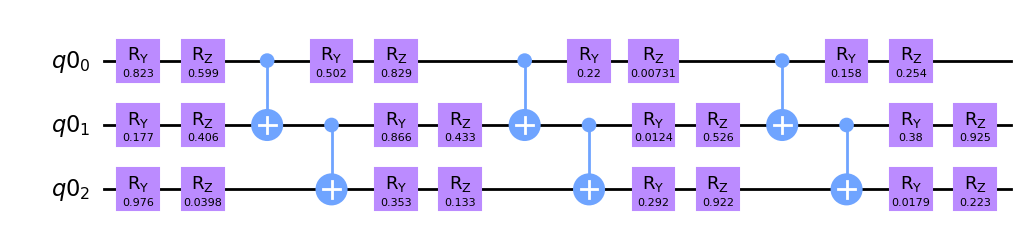

In [17]:
'''Qiskit_code_cell'''

nqubits = 3
nrounds = 4

qr = QuantumRegister(nqubits)
qc = QuantumCircuit(qr)
angles = np.random.rand(2*nqubits*nrounds)

qc = ansatz(qc, qr, thetas=angles, rounds=nrounds)

qc.draw('mpl')

En este caso concreto, tenemos puertas parametrizadas $R_Y$ y $R_Z$, cuyos ángulos de rotación son los parámetros $\boldsymbol{\theta}$ que vamos a ir modificando hasta llegar al autovalor mínimo. Por supuesto, podríamos haber utilizado también puertas $R_X$ o cualquier puerta que rotase los qubits en torno a un eje arbitrario.
<br>
<br>
Para entrelazar qubits hemos utilizado puertas $CNOT$, aunque también se suelen usar $CZ$.

Con todas estas herramientas, podemos definir la función ```matrix_decomposition_circuits```, que toma nuestro operador $\mathcal{H}$ y, utilizando ```pauli_decomposition```, lo convierte en una suma de cadenas de Pauli. Con esto define tantos circuitos cuánticos como cadenas tengamos, añadiendo a cada uno de ellos nuestro *ansatz* empleando ```ansatz``` (la función ```add_ansatz(qc, qr)``` se define con ella).
<br>
<br>
Después, dependiendo de como sean las cadenas de Pauli, añade los medidores que correspondan según la base (por ejemplo, si estamos midiendo en la dirección $Y$, debemos rotar nuestro qubit utilizando $H$ y $S^\dagger$).

In [9]:
'''Qibo_code_cell'''

def matrix_decomposition_circuits(H, add_ansatz):

    from qibo import models, gates

    # Definimos variables y comprobamos las dimensiones del Hamiltoniano
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    # Descomponemos el Hamiltoniano en cadenas de Pauli
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        qc = models.Circuit(n)
        
        # No hacemos nada si todas las Pauli son I, utilizamos este circuito vacío que medirá el estado "0" (autovalor 1) en todos los caso
        if all(x[1] == "I" for x in paulis):
            qc.add(gates.M(qc.nqubits-1))
            circuits[paulistring] = (qc, weight)
            continue

        # Al resto de posibles circuitos sí les añadimos el ansatz
        add_ansatz(qc,n)
            
        # Hacemos las transformaciones sobre un solo qubit
        for idx, letter in paulis:
            if letter == "X":
                qc.add(gates.H(idx))
            elif letter == "Y":
                qc.add(gates.H(idx))
                qc.add(gates.S(idx).dagger())
                
        # Añadimos las puertas multiqubit
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.add(gates.SWAP(first[0], second[0]))
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.add(gates.CNOT(first[0],second[0]))
                
        # Medimos sobre el último qubit
        qc.add(gates.M(qc.nqubits-1))
        circuits[paulistring] = (qc, weight)
        
        
    return circuits

In [18]:
'''Qiskit_code_cell'''

def matrix_decomposition_circuits(H, add_ansatz):

    # Definimos variables y comprobamos las dimensiones del Hamiltoniano
    
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc,qr)
        
        # No hacemos nada si todas las Pauli son I
        if all(x[1] == "I" for x in paulis):
            # utilizamos este circuito vacío que medirá el estado "0" (autovalor 1) en todos los casos
            circuits[paulistring] = (qc, weight)
            continue
            
        # Hacmos las transformaciones sobre un solo qubit
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
                
        # Añadimos las puertas multiqubit
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0],second[0])
                
        # Medimos sobre el último qubit
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc, weight)
        
    return circuits

Definimos ahora la función ```run_circuit```, que lo que hace es ejecutar el circuito utilizando el backend que hayamos especificado y nos devuelve el valor esperado de la medida del circuito.

In [10]:
'''Qibo_code_cell'''

def run_circuit(circuit, shots=10000):
    result = circuit.execute(nshots=shots)
    counts = result.frequencies(binary=True)
    return ((counts["0"] if "0" in counts.keys() else 0) - (counts["1"] if "1" in counts.keys() else 0))/shots

In [19]:
'''Qiskit_code_cell'''

def run_circuit(circuit, backend, shots=10000):
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    return ((counts["0"] if "0" in counts.keys() else 0) - (counts["1"] if "1" in counts.keys() else 0))/shots

Definimos ahora ```expectation```, que ejecuta los circuitos generados por ```matrix_decomposition_circuits``` utilizando ```run_circuit``` y suma sus resultados con los coeficientes de la descomposición, devolviendo el valor esperado del operador problema.

In [11]:
'''Qibo_code_cell'''

def expectation(H, rounds, thetas):
    circuits = matrix_decomposition_circuits(H, lambda qc,n: ansatz(qc, n, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0])*circuits[key][1], circuits.keys()))

In [20]:
'''Qiskit_code_cell'''

def expectation(H, rounds, thetas):
    backend = Aer.get_backend('statevector_simulator')
    circuits = matrix_decomposition_circuits(H, lambda qc,qr: ansatz(qc, qr, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))

Ahora definimos nuestro optimizador clásico. Vamos a utilizar un optimizador numérico conocido como SPSA (*Simultaneous Perturbation Stochastic Approximation*) [[4]](#bib_bhatnagar_stochastic_2013). Lo programamos a continuación para ver cómo funciona pero, de nuevo, en adelante utilizaremos optimizadores que podemos encontrar en las librerías.

In [21]:
class SPSA:
    
    def __init__(self, a, c, A, alpha, gamma, H, loss_function):
        # Inicializamos parámetros de ganancia y factores de decaímiento
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function
        
        # Contador
        self.t = 0
        
    def step(self, current_estimate):
        # Obtenemos los valores actuales para las secuencias de ganancia
        a_t = self.a / (self.t + 1 + self.A)**self.alpha
        c_t = self.c / (self.t + 1)**self.gamma
        
        # Vector de perturbaciones aleatorias de la distribución de Bernoulli
        delta = np.random.randint(0, 2, np.array(current_estimate).shape) * 2 - 1
        
        # Medimos la función de pérdida en las perturbaciones
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
        # Estimación del gradiente
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
        
        # Actualizamos la estimación del parámetro
        current_estimate = current_estimate - a_t * g_t
        
        # Incrementamos el contador
        self.t +=1
        
        return current_estimate

Y ya, con un optimizador clásico y un operador cuántico, podemos definir nuestro algoritmo VQE, utilizando la función ```expectation``` como función de pérdida del optimizador (implementando aquí toda la circuitería cuántica).

In [22]:
def vqe(H, rounds, max_iter, thetas=None, save_steps = None):
   
    cnt_qubits = int(np.log2(len(H)))
    if thetas is None:
        thetas = list(map(lambda x: random.random(), [0] * ((1+rounds)*cnt_qubits*2)))
        
    # Creamos la clase del optimizador
    optimizer = SPSA(a = 0.9, c = 1.0, A = max_iter/10, alpha = 0.602, gamma = 0.101, H = H, loss_function = lambda t_thetas: expectation(H, rounds, t_thetas))
    
    # Loop principal
    for i in range(max_iter):
        thetas = optimizer.step(thetas)
        
        if save_steps is not None and i % save_steps == 0:
            yield (i, thetas, expectation(H, rounds, thetas))
            
    return (thetas, expectation(H, rounds, thetas))

Y con todo este código podemos meter la matriz que diagonalizamos antes a mano y comprobar que, efectivamente, el autovalor más bajo que obtenemos es $E_G \simeq 1$.

In [ ]:
H = op

result = None
step_size = 3

result_energy = []

for step in vqe(H, rounds=3, max_iter=1002, save_steps = step_size):
    result_energy.append(step[2])
    print('Paso {step}. Valor actual de la función de coste: {ev: .3f}'.format(step=step[0], ev = step[2]))
    result = step
    
print('Los parámetros óptimos para este circuito son: [\n'
     + "".join(["\t"+str(round(t,3))
     +",\n" if i%3 == 2 else "\t"+str(round(t,3))
     +",\t" for i, t in enumerate(result[1])])+"]")
print('El valor del autovalor mínimo es: {ev: .3f}'.format(ev=result[2]))

Paso 0. Valor actual de la función de coste:  3.066
Paso 3. Valor actual de la función de coste:  3.012
Paso 6. Valor actual de la función de coste:  2.946
Paso 9. Valor actual de la función de coste:  2.906
Paso 12. Valor actual de la función de coste:  2.896
Paso 15. Valor actual de la función de coste:  2.768
Paso 18. Valor actual de la función de coste:  2.726
Paso 21. Valor actual de la función de coste:  2.606
Paso 24. Valor actual de la función de coste:  2.554
Paso 27. Valor actual de la función de coste:  2.558
Paso 30. Valor actual de la función de coste:  2.564
Paso 33. Valor actual de la función de coste:  2.557
Paso 36. Valor actual de la función de coste:  2.264
Paso 39. Valor actual de la función de coste:  2.222
Paso 42. Valor actual de la función de coste:  2.170
Paso 45. Valor actual de la función de coste:  2.093
Paso 48. Valor actual de la función de coste:  2.027
Paso 51. Valor actual de la función de coste:  2.031
Paso 54. Valor actual de la función de coste:  1.9

In [ ]:
# Con la información de las iteraciones podemos dibujar la convergencia de nuestro código

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(result_energy)), result_energy, label="Valor de la energía", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Paso', fontsize = fontsize)
plt.ylabel('Energía', fontsize = fontsize)
plt.title('Convergencia de la energía con el optimizador SPSA', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize)
plt.show()

Por supuesto, aunque con este código abordamos los principios básicos del algoritmo y podemos obtener una aproximacion decente de $E_G$ para matrices pequeñas, este algoritmo se puede implementar de forma más eficaz, rápida y con mayor precisión en operadores de mayor dimensionalidad.

En resumen, en el algoritmo VQE se fabrica un circuito cuántico (*ansatz*) parametrizado ($\boldsymbol{\theta}$), se ejecuta para obtener el valor esperado del operador problema ($E (\boldsymbol{\theta})$) y se envía el resultado a un optimizador clásico (```SPSA```) para que reajuste los parámetros. A lo largo de varias iteraciones, el algoritmo converge a un valor en torno a $E_G$.

El punto clave del algoritmo VQE, y de los algoritmos variacionales en general, es que, al ser repeticiones de un proceso parametrizado, los posibles errores inducidos por el circuito cuántico (puertas, cross-talking, recaída al fundamental...) al final son contemplados por las sucesivas elecciones de los parámetros, haciéndolo más robusto. Esto hace que, en esta era de la computación NISQ en la que vivimos, sea un algoritmo aplicable e implementable, al menos para casos lo suficientemente sencillos y que no demanden muchos recursos.
<br>
<br>
Y es una suerte que esto sea así, porque los problemas de diagonalización y obtención del autovalor más bajo son de vital importancia en muchas ramas de la ciencia, como puede ser la química teórica [[1]](#bib_peruzzo_variational_2014), [[2]](#bib_tilly_variational_2022) o la física nuclear [[5]](#bib_cervia_lipkin_2021), [[6]](#bib_grimsley_adaptive_2019), [[7]](#bib_romero_solving_2022), así como en problemas de otras disciplinas, como la economía (*travelling salesman*, *max-cut*) [[3]](#bib_zickert_hands_quantum_2022).
<br>
<br>
Los puntos claves de este algoritmo para aumentar las posibilidades y la velocidad de convergencia son la elección del *ansatz* (que al final determina la cantidad de recursos demandados y varias de las condiciones del problema a resolver) y del algoritmo de optimizador clásico (que debe lidiar con múltiples problemas en el espacio de parámetros, como los mínimos locales o los *barren plateaus*). En los siguientes apartados de esta documentación hablaremos más sobre estos dos temas.

<a id="Bibliografía"></a>
## Bibliografía

[1] Peruzzo, A., McClean, J., Shadbolt, P., Yung, M.-H., Zhou, X.-Q., Love, P.J., Aspuru-Guzik, A., O’Brien, J.L., (2014). 'A variational eigenvalue solver on a photonic quantum processor'. *Nat Commun* 5, 4213. https://doi.org/10.1038/ncomms5213 <a id='bib_peruzzo_variational_2014'></a>

[2] Tilly, J., Chen, H., Cao, S., Picozzi, D., Setia, K., Li, Y., Grant, E., Wossnig, L., Rungger, I., Booth, G.H., Tennyson, J., (2022). 'The Variational Quantum Eigensolver: A review of methods and best practices'. *Physics Reports*, The Variational Quantum Eigensolver: a review of methods and best practices 986, 1–128. https://doi.org/10.1016/j.physrep.2022.08.003 <a id='bib_tilly_variational_2022'></a>

[3] Zickert, F., (2022). *Hands-On Quantum Machine Learning With Python*. PyQML. <a id='bib_zickert_hands_quantum_2022'></a>

[4] Bhatnagar, S., Prasad, H.L., Prashanth, L.A., (2013). *Stochastic Recursive Algorithms for Optimization*, Lecture Notes in Control and Information Sciences. Springer London, London. https://doi.org/10.1007/978-1-4471-4285-0 <a id='bib_bhatnagar_stochastic_2013'></a>

[5] Cervia, Michael J., A. B. Balantekin, S. N. Coppersmith, Calvin W. Johnson, Peter J. Love, C. Poole, K. Robbins, y M. Saffman. «Lipkin Model on a Quantum Computer». Physical Review C 104, n.º 2 (3 de agosto de 2021): 024305. https://doi.org/10.1103/PhysRevC.104.024305. <a id='bib_cervia_lipkin_2021'></a>

[6] Grimsley, Harper R., Sophia E. Economou, Edwin Barnes, y Nicholas J. Mayhall. «An Adaptive Variational Algorithm for Exact Molecular Simulations on a Quantum Computer». Nature Communications 10, n.º 1 (8 de julio de 2019): 3007. https://doi.org/10.1038/s41467-019-10988-2. <a id='bib_grimsley_adaptive_2019'></a>

[7] Romero, A. M., J. Engel, Ho Lun Tang, y Sophia E. Economou. «Solving Nuclear Structure Problems with the Adaptive Variational Quantum Algorithm». Physical Review C 105, n.º 6 (27 de junio de 2022): 064317. https://doi.org/10.1103/PhysRevC.105.064317. <a id='bib_romero_solving_2022'></a>

---
Authors:

Irais Bautista ([CESGA](http://www.cesga.es)), Sergio Martínez ([BIFi-UNIZAR](https://bifi.es/es/)), Jaime Scharfhausen ([UAM](https://www.uam.es/uam/inicio)) y Alejandro Jaramillo ([CSUC](https://www.csuc.cat/es))

<img src="https://quantumspain-project.es/wp-content/uploads/2022/11/CESGA.png" width="150px">
<img src="http://bifi.es/wp-content/uploads/2016/11/logo_vectorial-web.png" width="200px">
<img src="https://www.iib.uam.es/iiblf6theme-theme/images/custom/logo-uam.png" width = "200px">
<img src="https://www.csuc.cat/sites/default/files/2021-02/CSUC_logo_corporatiu_0.png" width = "200px">


---
<figure><center>
<img   src="https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png" align=center  width="2000px"/>
</center></figure>

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>